In [1]:
# 📚 Libraries 
import kagglehub
import pandas as pd
import numpy as np
import os

# New liabraries. 
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as g

# 🤖 Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

In [2]:
# Download latest version
#path = kagglehub.dataset_download("andrewmvd/sp-500-stocks")


In [3]:
# Print all files in the dataset path
#print(os.listdir(path))

In [4]:
#csv_file_path = os.path.join(path, 'sp500_stocks.csv')
#csv_file_path2 = os.path.join(path, 'sp500_companies.csv')
#csv_file_path3 = os.path.join(path, 'sp500_index.csv')
#data = pd.read_csv(csv_file_path)
#df = pd.read_csv(csv_file_path2)
#sp = pd.read_csv(csv_file_path3)

In [2]:
data = pd.read_csv('sp500_stocks.csv')
df = pd.read_csv('sp500_companies.csv')
sp = pd.read_csv('sp500_index.csv')

In [3]:
data.columns = [col.lower().replace(" ", "_")for col in data.columns] #snake_case
df.columns = [col.lower().replace(" ", "_")for col in df.columns] #snake_case
sp.columns = [col.lower().replace(" ", "_")for col in sp.columns] #snake_case

In [4]:
# Copies 
data2 = data.copy()
df2 = df.copy()
sp2 = sp.copy()

In [5]:
data2.dtypes

date          object
symbol        object
adj_close    float64
close        float64
high         float64
low          float64
open         float64
volume       float64
dtype: object

In [6]:
data.isna().sum()

date              0
symbol            0
adj_close    101626
close        101626
high         101626
low          101626
open         101626
volume       101626
dtype: int64

In [7]:
# Delete Columns 
data2.drop(columns=['high', 'low', 'open','close'], inplace=True)

In [8]:
data2.isna().sum()

date              0
symbol            0
adj_close    101626
volume       101626
dtype: int64

In [9]:
# Delete NaN. TELL WHY I'M dropping 
data2.dropna(how='any', inplace=True)

In [10]:
data2.isna().sum()

date         0
symbol       0
adj_close    0
volume       0
dtype: int64

In [11]:
# Change to datetime. 
data2['date'] = pd.to_datetime(data2['date'])
# Change to datetime. SP 500. 
sp['date'] = pd.to_datetime(sp['date'])

In [12]:
data2['year'] = data2['date'].dt.year
data2['month'] = data2['date'].dt.month
data2['day'] = data2['date'].dt.day
sp['year'] = sp['date'].dt.year
sp['month'] = sp['date'].dt.month
sp['day'] = sp['date'].dt.day

In [13]:
cols = ['year', 'month', 'day', 'symbol', 'adj_close', 'volume']
data2 = data2[cols]
data2.head(3)

,year,month,day,symbol,adj_close,volume
0,2010,1,4,MMM,43.783867,3640265.0
1,2010,1,5,MMM,43.509628,3405012.0
2,2010,1,6,MMM,44.126682,6301126.0


In [14]:
# Drop rows where year is between 2010 and 2013 because SP500 for comparison we do have 2014. 
data2.drop(data2[(data2['year'] >= 2010) & (data2['year'] <= 2014)].index, inplace=True)
# Drop row for sp 500 as we do not have many. 
sp.drop(sp[sp['year'] == 2014].index, inplace=True)

In [15]:
# Chat helped. 
annual_returns = data2.groupby(['symbol', 'year']).apply(lambda group: (group['adj_close'].iloc[-1] / group['adj_close'].iloc[0]) - 1).reset_index(name='annual_return').round(4)

/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_14587/292607746.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns = data2.groupby(['symbol', 'year']).apply(lambda group: (group['adj_close'].iloc[-1] / group['adj_close'].iloc[0]) - 1).reset_index(name='annual_return').round(4)


In [16]:
annual_returns

,symbol,year,annual_return
0,A,2015,0.0418
1,A,2016,0.1319
2,A,2017,0.4535
3,A,2018,0.0072
4,A,2019,0.3098
...,...,...,...
4897,ZTS,2020,0.2409
4898,ZTS,2021,0.4999
4899,ZTS,2022,-0.3692
4900,ZTS,2023,0.3563


In [17]:
pivoted_df = annual_returns.pivot(index='symbol', columns='year', values='annual_return')
pivoted_df.sample(3)

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
MO,0.2387,0.2216,0.0943,-0.2645,0.0805,-0.0901,0.2467,0.0311,-0.0330,0.4684
FAST,-0.1151,0.2039,0.1974,-0.0134,0.4756,0.3557,0.3738,-0.2180,0.4107,0.3041
BLDR,0.6415,-0.0108,0.8720,-0.5041,1.2076,0.6061,1.1519,-0.2229,1.5546,0.0631


In [18]:
cols = ['year', 'month', 'day', 's&p500']
sp = sp[cols]
sp.head(3)

,year,month,day,s&p500
17,2015,1,2,2058.20
18,2015,1,5,2020.58
19,2015,1,6,2002.61


In [19]:
annual_returns_sp = sp.groupby('year').apply(lambda group: (group['s&p500'].iloc[-1] / group['s&p500'].iloc[0]) - 1).reset_index(name='annual_return').round(4)

/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_14587/2067876651.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns_sp = sp.groupby('year').apply(lambda group: (group['s&p500'].iloc[-1] / group['s&p500'].iloc[0]) - 1).reset_index(name='annual_return').round(4)


In [20]:
annual_returns_sp

,year,annual_return
0,2015,-0.0069
1,2016,0.1124
2,2017,0.1842
3,2018,-0.0701
4,2019,0.2871
5,2020,0.1529
6,2021,0.2879
7,2022,-0.1995
8,2023,0.2473
9,2024,0.2809


In [21]:
annual_returns_sp['symbol'] = 's&p500'

In [22]:
annual_returns_sp

,year,annual_return,symbol
0,2015,-0.0069,s&p500
1,2016,0.1124,s&p500
2,2017,0.1842,s&p500
3,2018,-0.0701,s&p500
4,2019,0.2871,s&p500
5,2020,0.1529,s&p500
6,2021,0.2879,s&p500
7,2022,-0.1995,s&p500
8,2023,0.2473,s&p500
9,2024,0.2809,s&p500


In [23]:
cols = ['symbol', 'year', 'annual_return']
annual_returns_sp = annual_returns_sp[cols]

In [24]:
annual_returns_sp

,symbol,year,annual_return
0,s&p500,2015,-0.0069
1,s&p500,2016,0.1124
2,s&p500,2017,0.1842
3,s&p500,2018,-0.0701
4,s&p500,2019,0.2871
5,s&p500,2020,0.1529
6,s&p500,2021,0.2879
7,s&p500,2022,-0.1995
8,s&p500,2023,0.2473
9,s&p500,2024,0.2809


In [25]:
pivoted_sp = annual_returns_sp.pivot(index='symbol',columns='year', values='annual_return')
pivoted_sp

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
s&p500,-0.0069,0.1124,0.1842,-0.0701,0.2871,0.1529,0.2879,-0.1995,0.2473,0.2809


In [26]:
defi = pd.concat([pivoted_df,pivoted_sp], axis=0) 
defi

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
A,0.0418,0.1319,0.4535,0.0072,0.3098,0.3875,0.3512,-0.0374,-0.0666,0.0183
AAPL,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145
ABBV,-0.0714,0.1290,0.6061,-0.0267,0.0483,0.2628,0.3461,0.2399,-0.0071,0.1427
ABNB,NaN,NaN,NaN,NaN,NaN,0.0144,0.1965,-0.5049,0.6035,0.0181
ABT,0.0214,-0.0828,0.4954,0.2529,0.2705,0.2791,0.3098,-0.1971,0.0246,0.0733
...,...,...,...,...,...,...,...,...,...,...
YUM,0.0321,0.2488,0.3134,0.1462,0.1200,0.0830,0.3342,-0.0439,0.0485,0.0879
ZBH,-0.0810,0.0227,0.1774,-0.1565,0.4745,0.0413,-0.1650,0.0170,-0.0438,-0.1101
ZBRA,-0.1005,0.2898,0.2035,0.5353,0.6349,0.4831,0.5741,-0.5609,0.0505,0.5274


In [27]:
definitive = pd.merge (df, defi, on='symbol')
definitive.tail(10)

,exchange,symbol,shortname,longname,sector,industry,currentprice,marketcap,ebitda,revenuegrowth,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
493,NMS,CZR,"Caesars Entertainment, Inc.","Caesars Entertainment, Inc.",Consumer Cyclical,Resorts & Casinos,37.60,7989247488,3.668000e+09,-0.040,...,1.7228,0.6006,0.9443,0.1441,0.5715,0.2480,0.3063,-0.5549,0.1093,-0.2131
494,NMS,APA,APA Corporation,APA Corporation,Energy,Oil & Gas E&P,21.42,7924264960,5.047000e+09,0.104,...,-0.2906,0.4579,-0.3246,-0.3937,-0.0209,-0.4320,0.8327,0.6700,-0.1774,-0.4068
495,NMS,PARA,Paramount Global,Paramount Global,Communication Services,Entertainment,10.99,7868004352,3.125000e+09,-0.056,...,-0.1299,0.3805,-0.0729,-0.2508,-0.0702,-0.0784,-0.1568,-0.4552,-0.1143,-0.2261
496,NYQ,CE,Celanese Corporation,Celanese Corporation,Basic Materials,Chemicals,70.54,7710868480,1.851000e+09,-0.028,...,0.1425,0.2159,0.3718,-0.1405,0.3795,0.0976,0.3594,-0.3868,0.5192,-0.5441
497,NMS,WBA,"Walgreens Boots Alliance, Inc.","Walgreens Boots Alliance, Inc.",Healthcare,Pharmaceutical Retailers,8.56,7401122304,2.884000e+09,0.060,...,0.1392,0.0150,-0.1073,-0.0665,-0.1061,-0.2952,0.3080,-0.2633,-0.2474,-0.6525
498,NYQ,BWA,BorgWarner Inc.,BorgWarner Inc.,Consumer Cyclical,Auto Parts,33.80,7392059904,1.882000e+09,-0.048,...,-0.2022,-0.0517,0.2918,-0.3189,0.2572,-0.1037,0.2019,-0.0940,0.0245,-0.0471
499,NYQ,HII,"Huntington Ingalls Industries,","Huntington Ingalls Industries, Inc.",Industrials,Aerospace & Defense,187.95,7354351616,1.071000e+09,-0.024,...,0.1491,0.5029,0.2615,-0.1545,0.3244,-0.3181,0.1651,0.2680,0.1633,-0.2620
500,NYQ,FMC,FMC Corporation,FMC Corporation,Basic Materials,Agricultural Inputs,56.58,7063221248,7.033000e+08,0.085,...,-0.3028,0.5106,0.6741,-0.2186,0.5627,0.1725,-0.0103,0.1542,-0.4807,-0.1023
501,NMS,QRVO,"Qorvo, Inc.","Qorvo, Inc.",Technology,Semiconductors,68.33,6459010048,6.731300e+08,-0.052,...,-0.2770,0.0396,0.2590,-0.1183,0.8998,0.4339,-0.0498,-0.4315,0.2633,-0.3726
502,NYQ,AMTM,"Amentum Holdings, Inc.","Amentum Holdings, Inc.",Industrials,Specialty Business Services,23.17,5637307392,4.330000e+08,-0.031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.2148


In [28]:
definitive.shape

(503, 26)

In [29]:
definitive = definitive.rename(columns={2015: 'ar_2015',2016:'ar_2016',2017: 'ar_2017', 
                                          2018:'ar_2018', 2019: 'ar_2019',2020: 'ar_2020', 2021: 'ar_2021', 2022:'ar_2022', 2023:'ar_2023',2024: 'ar_2024'})

In [30]:
#Dropping Columns: Exchange, longname, longbusinesssumary. 
cols = ['symbol', 'shortname','sector','industry',
        'marketcap','ebitda', 'revenuegrowth', 'city', 'state', 'country',   
        'fulltimeemployees', 'weight', 'ar_2015', 'ar_2016', 'ar_2017', 'ar_2018', 'ar_2019',
        'ar_2020', 'ar_2021', 'ar_2022', 'ar_2023', 'ar_2024', 'currentprice']

In [31]:
definitive = definitive[cols]

In [32]:
definitive

,symbol,shortname,sector,industry,marketcap,ebitda,revenuegrowth,city,state,country,...,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
0,AAPL,Apple Inc.,Technology,Consumer Electronics,3670720643072,1.346610e+11,0.061,Cupertino,CA,United States,...,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145,242.84
1,NVDA,NVIDIA Corporation,Technology,Semiconductors,3488355713024,6.118400e+10,1.224,Santa Clara,CA,United States,...,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580,142.44
2,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,3297889746944,1.365520e+11,0.160,Redmond,WA,United States,...,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050,443.57
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,2387220627456,1.115830e+11,0.110,Seattle,WA,United States,...,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142,227.03
4,GOOG,Alphabet Inc.,Communication Services,Internet Content & Information,2149065949184,1.234700e+11,0.151,Mountain View,CA,United States,...,0.0404,0.3311,-0.0276,0.2784,0.2812,0.6743,-0.3884,0.5711,0.2646,176.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,BWA,BorgWarner Inc.,Consumer Cyclical,Auto Parts,7392059904,1.882000e+09,-0.048,Auburn Hills,MI,United States,...,-0.0517,0.2918,-0.3189,0.2572,-0.1037,0.2019,-0.0940,0.0245,-0.0471,33.80
499,HII,"Huntington Ingalls Industries,",Industrials,Aerospace & Defense,7354351616,1.071000e+09,-0.024,Newport News,VA,United States,...,0.5029,0.2615,-0.1545,0.3244,-0.3181,0.1651,0.2680,0.1633,-0.2620,187.95
500,FMC,FMC Corporation,Basic Materials,Agricultural Inputs,7063221248,7.033000e+08,0.085,Philadelphia,PA,United States,...,0.5106,0.6741,-0.2186,0.5627,0.1725,-0.0103,0.1542,-0.4807,-0.1023,56.58
501,QRVO,"Qorvo, Inc.",Technology,Semiconductors,6459010048,6.731300e+08,-0.052,Greensboro,NC,United States,...,0.0396,0.2590,-0.1183,0.8998,0.4339,-0.0498,-0.4315,0.2633,-0.3726,68.33


In [33]:
cat = definitive.select_dtypes(exclude='number')
cat.head(5)

,symbol,shortname,sector,industry,city,state,country
0,AAPL,Apple Inc.,Technology,Consumer Electronics,Cupertino,CA,United States
1,NVDA,NVIDIA Corporation,Technology,Semiconductors,Santa Clara,CA,United States
2,MSFT,Microsoft Corporation,Technology,Software - Infrastructure,Redmond,WA,United States
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,Seattle,WA,United States
4,GOOG,Alphabet Inc.,Communication Services,Internet Content & Information,Mountain View,CA,United States


In [34]:
num = definitive.select_dtypes(include='number')
num.head(5)

,marketcap,ebitda,revenuegrowth,fulltimeemployees,weight,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024,currentprice
0,3670720643072,1.346610e+11,0.061,164000.0,0.064589,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145,242.84
1,3488355713024,6.118400e+10,1.224,29600.0,0.061381,0.6645,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580,142.44
2,3297889746944,1.365520e+11,0.160,228000.0,0.058029,0.2188,0.1651,0.3974,0.2022,0.5826,0.3994,0.5579,-0.2769,0.5835,0.2050,443.57
3,2387220627456,1.115830e+11,0.110,1551000.0,0.042005,1.1907,0.1772,0.5517,0.2632,0.2006,0.7160,0.0464,-0.5071,0.7704,0.5142,227.03
4,2149065949184,1.234700e+11,0.151,181269.0,0.037815,0.4500,0.0404,0.3311,-0.0276,0.2784,0.2812,0.6743,-0.3884,0.5711,0.2646,176.49


In [35]:
defi

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
A,0.0418,0.1319,0.4535,0.0072,0.3098,0.3875,0.3512,-0.0374,-0.0666,0.0183
AAPL,-0.0208,0.1238,0.4804,-0.0705,0.8874,0.7824,0.3806,-0.2820,0.5480,0.3145
ABBV,-0.0714,0.1290,0.6061,-0.0267,0.0483,0.2628,0.3461,0.2399,-0.0071,0.1427
ABNB,NaN,NaN,NaN,NaN,NaN,0.0144,0.1965,-0.5049,0.6035,0.0181
ABT,0.0214,-0.0828,0.4954,0.2529,0.2705,0.2791,0.3098,-0.1971,0.0246,0.0733
...,...,...,...,...,...,...,...,...,...,...
YUM,0.0321,0.2488,0.3134,0.1462,0.1200,0.0830,0.3342,-0.0439,0.0485,0.0879
ZBH,-0.0810,0.0227,0.1774,-0.1565,0.4745,0.0413,-0.1650,0.0170,-0.0438,-0.1101
ZBRA,-0.1005,0.2898,0.2035,0.5353,0.6349,0.4831,0.5741,-0.5609,0.0505,0.5274


In [36]:
frequency_table = cat.sector.value_counts()
proportion_table = cat.sector.value_counts(normalize=True)

In [37]:
frequency_proportion = pd.concat([frequency_table,proportion_table], axis = 1)
frequency_proportion.columns = ['absolute_frequency', 'relative_frequency']
frequency_proportion

,absolute_frequency,relative_frequency
sector,,
Technology,82,0.163022
Industrials,70,0.139165
Financial Services,67,0.133201
Healthcare,63,0.125249
Consumer Cyclical,55,0.109344
Consumer Defensive,37,0.073559
Utilities,32,0.063618
Real Estate,31,0.061630
Communication Services,22,0.043738


In [38]:
total_absolute = frequency_table.sum()
total_relative = proportion_table.sum()

In [39]:
total_row = pd.DataFrame({
    'absolute_frequency': [total_absolute],
    'relative_frequency': [total_relative]
}, index=['Total'])
total_row

,absolute_frequency,relative_frequency
Total,503,1.0


In [40]:
df3 = pd.concat([frequency_proportion, total_row])

In [41]:
df3

,absolute_frequency,relative_frequency
Technology,82,0.163022
Industrials,70,0.139165
Financial Services,67,0.133201
Healthcare,63,0.125249
Consumer Cyclical,55,0.109344
Consumer Defensive,37,0.073559
Utilities,32,0.063618
Real Estate,31,0.061630
Communication Services,22,0.043738
Energy,22,0.043738


/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_14587/3055570902.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


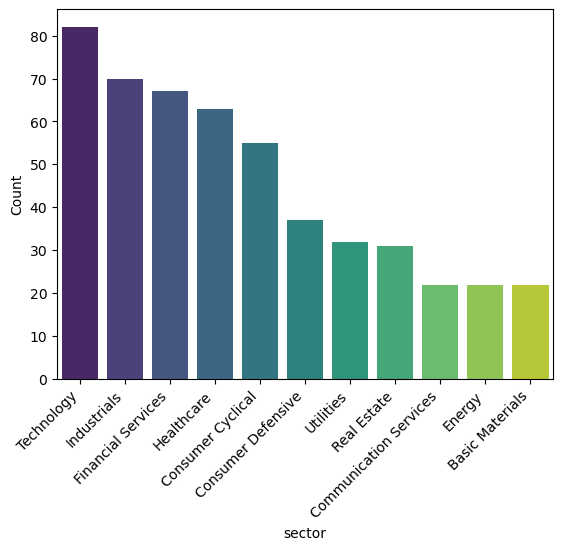

In [42]:
sns.barplot(
    x='sector',
    y='absolute_frequency',
    data=frequency_proportion,
    palette='viridis',
)
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

The frequency table gives the count of each sector, while the proportion table provides the percentage representation of each category in the dataset. This helps to quickly identify dominant and minority categories. Such as:
- Technology: 16% 
- Industrials: 14% 
- Financial Services: 13% 
- Healthcare: 12% 
- Consumer Cyclical: 10% 

In [43]:
tech = definitive[definitive['sector'] == 'Technology']
indus = definitive[definitive['sector'] == 'Industrials']
fin = definitive[definitive['sector'] == 'Financial Services']
health = definitive[definitive['sector'] == 'Healthcare']
consumer = definitive[definitive['sector'] == 'Consumer Cyclical']

In [44]:
tech['revenuegrowth'].mean()

0.11582716049382717

In [45]:
consumer['revenuegrowth'].mean()

0.06743636363636363

/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_14587/1208744207.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x="shortname", y="sector", data=sector_breakdown, palette=('coolwarm'))
/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_14587/1208744207.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x="marketcap", y="sector", data=sector_breakdown, palette=('Wistia'))
/var/folders/bs/hzz4qdm57z9cct0t_9rdynfr0000gn/T/ipykernel_14587/1208744207.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(

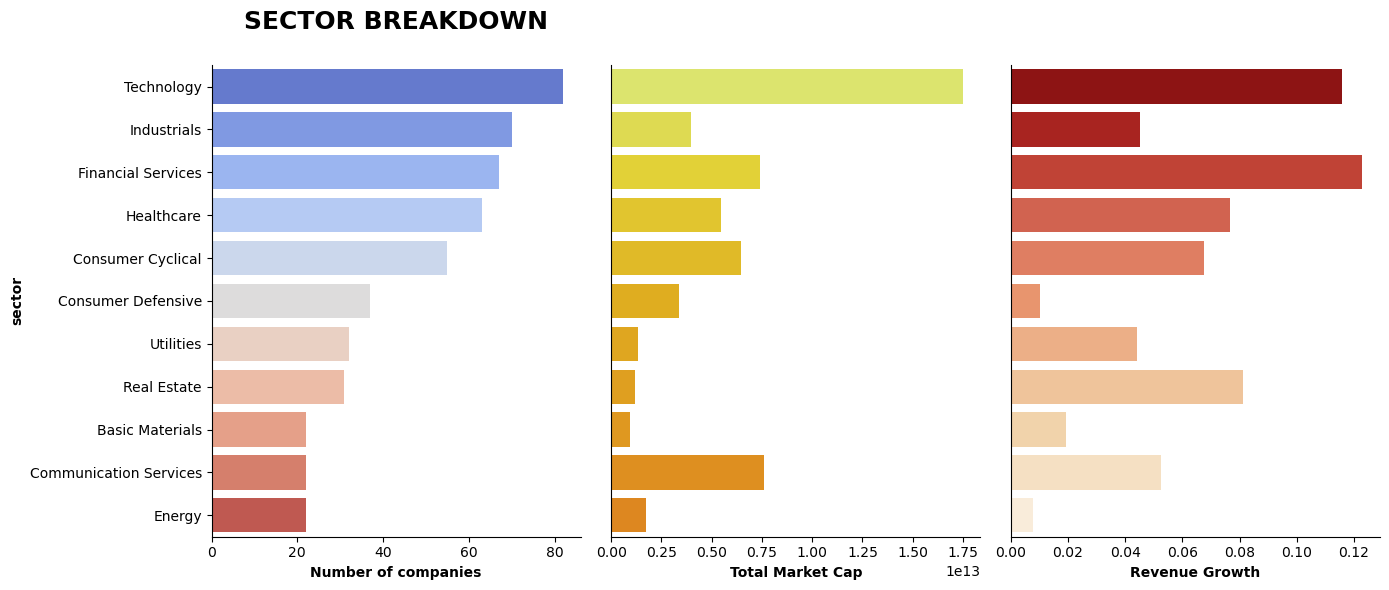

In [46]:
# Found out in Kaggle related notebooks. 
f = {'revenuegrowth':['mean'], 'marketcap':['sum'], 'shortname':['count']}

sector_breakdown = definitive.groupby('sector').agg(f)
sector_breakdown.columns = sector_breakdown.columns.get_level_values(0)
sector_breakdown = sector_breakdown.reset_index()
sector_breakdown = sector_breakdown.sort_values('shortname', ascending=False)

fig = plt.figure(num=None, figsize=(14, 6), dpi=100, facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
ax1 = sns.barplot(x="shortname", y="sector", data=sector_breakdown, palette=('coolwarm'))
ax1.set_xlabel('Number of companies', weight='bold')
ax1.set_ylabel('sector', weight = 'bold')
ax1.set_title('SECTOR BREAKDOWN\n', weight='bold').set_fontsize('18')

plt.subplot(1, 3, 2)
ax2 = sns.barplot(x="marketcap", y="sector", data=sector_breakdown, palette=('Wistia'))
ax2.set_xlabel('Total Market Cap', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

plt.subplot(1, 3, 3)
ax2 = sns.barplot(x="revenuegrowth", y="sector", data=sector_breakdown, palette=('OrRd_r'))
ax2.set_xlabel('Revenue Growth', weight='bold')
ax2.set_ylabel('')
ax2.set_yticks([])

sns.despine()
plt.tight_layout();

In [47]:
round(definitive.groupby('sector')['revenuegrowth'].agg(['count','mean', 'median', 'max']), 2)

,count,mean,median,max
sector,,,,
Basic Materials,22,0.02,0.00,0.85
Communication Services,21,0.05,0.04,0.19
Consumer Cyclical,55,0.07,0.04,1.63
Consumer Defensive,37,0.01,-0.00,0.27
Energy,22,0.01,-0.01,0.20
Financial Services,67,0.12,0.12,1.33
Healthcare,63,0.08,0.06,0.31
Industrials,70,0.05,0.03,0.49
Real Estate,30,0.08,0.07,0.29


In [48]:
results = definitive.groupby('sector')[['ar_2015', 'ar_2016', 'ar_2017','ar_2018', 'ar_2019', 'ar_2020','ar_2021','ar_2022','ar_2023','ar_2024' ]].agg(['mean']).round(4)
results


,ar_2015,ar_2016,ar_2017,ar_2018,ar_2019,ar_2020,ar_2021,ar_2022,ar_2023,ar_2024
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
sector,,,,,,,,,,
Basic Materials,-0.0515,0.3317,0.2620,-0.1485,0.2362,0.2180,0.3918,-0.0591,0.0989,0.0123
Communication Services,0.1711,0.1851,0.2660,-0.0479,0.2880,0.2042,0.1508,-0.2962,0.2704,0.2761
Consumer Cyclical,0.1161,0.1185,0.3184,-0.0525,0.3259,0.2717,0.3050,-0.1924,0.3123,0.2229
Consumer Defensive,0.1367,0.0827,0.1464,-0.0459,0.2970,0.1340,0.1715,0.0250,-0.0458,0.0367
Energy,-0.2032,0.4439,0.0230,-0.1985,0.1119,-0.2809,0.6197,0.5490,0.0717,0.1900
Financial Services,0.0260,0.2298,0.2444,-0.0898,0.3654,0.0585,0.3616,-0.0795,0.1322,0.3329
Healthcare,0.1084,0.0638,0.2840,0.0600,0.3132,0.2895,0.2844,-0.0590,0.0447,0.0128
Industrials,-0.0132,0.2783,0.2927,-0.1018,0.3946,0.2213,0.3149,-0.0760,0.2692,0.2754


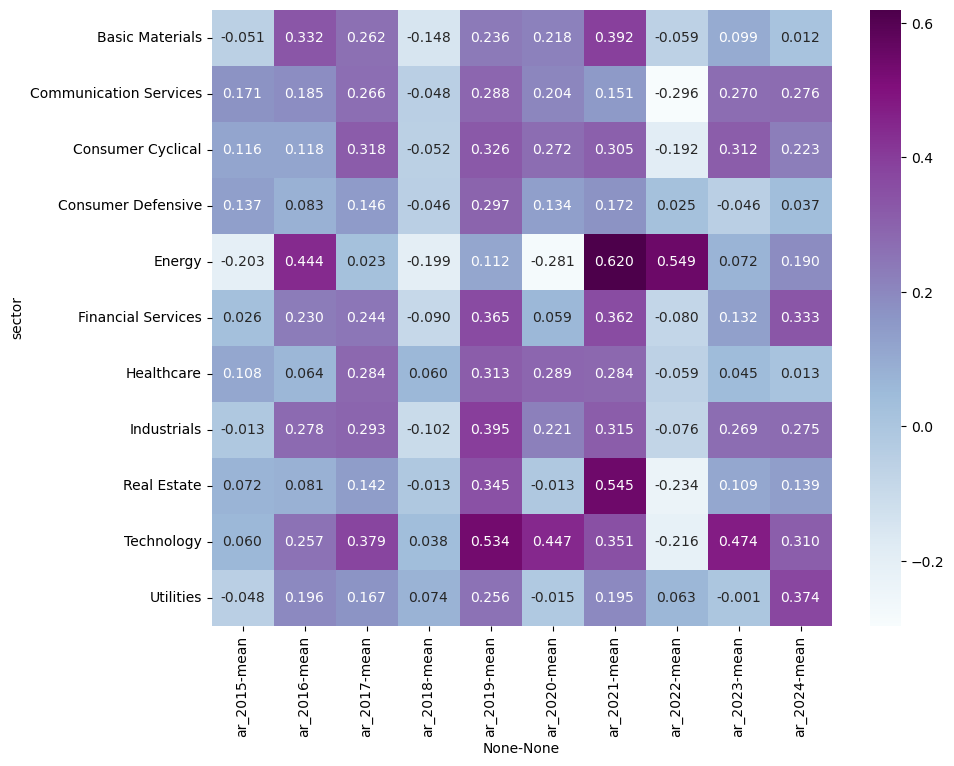

In [49]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(results, annot=True, cmap="BuPu", fmt=".3f")
plt.show()

In [50]:
sorted_df = defi.sort_values(by=2024, ascending=False)
sorted_df

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
PLTR,NaN,NaN,NaN,NaN,NaN,1.4789,-0.2208,-0.6535,1.6870,3.6043
VST,NaN,0.1662,0.1927,0.2427,0.0480,-0.1129,0.2257,0.0521,0.7787,3.2378
NVDA,0.6645,2.3292,0.9043,-0.3285,0.7341,1.1802,1.2448,-0.5144,2.4610,1.9580
AXON,-0.3478,0.4403,0.0781,0.6478,0.6245,0.6004,0.3436,0.0854,0.5355,1.7329
TPL,0.1117,1.3837,0.4975,0.1851,0.3910,-0.0243,0.6648,0.8750,-0.2463,1.5535
...,...,...,...,...,...,...,...,...,...,...
DLTR,0.0977,-0.0207,0.3855,-0.1690,0.0313,0.1521,0.3140,0.0019,0.0128,-0.4958
CE,0.1425,0.2159,0.3718,-0.1405,0.3795,0.0976,0.3594,-0.3868,0.5192,-0.5441
INTC,-0.0240,0.1023,0.2969,0.0269,0.3030,-0.1608,0.0637,-0.4836,0.9238,-0.5565


In [52]:
sample_df = sorted_df.sample(10)

In [54]:
sample_df

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
symbol,,,,,,,,,,
BMY,0.1829,-0.1122,0.0588,-0.1294,0.2664,0.0104,0.0397,0.1988,-0.2646,0.1824
SOLV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0124
PCAR,-0.2725,0.3908,0.1232,-0.1757,0.4324,0.1116,0.0757,0.1671,0.5586,0.2108
USB,-0.0256,0.2695,0.0643,-0.1309,0.3175,-0.1773,0.2559,-0.2385,-0.0305,0.1883
CRM,0.3234,-0.1075,0.4492,0.3118,0.1999,0.3326,0.1535,-0.4810,0.9524,0.4196
CTAS,0.2158,0.3258,0.3543,0.1217,0.6709,0.3190,0.3284,0.0928,0.3988,0.5425
AME,0.0252,-0.0700,0.4809,-0.0625,0.4873,0.2090,0.2497,-0.0209,0.1813,0.1817
CNC,0.2602,-0.1442,0.7301,0.1239,0.1127,-0.0299,0.3271,-0.0077,-0.0694,-0.2612
CINF,0.1953,0.3526,0.0229,0.0900,0.4218,-0.1480,0.3780,-0.0722,0.0238,0.5032


In [53]:
sample_df2 = sample_df.pivot(index='year',columns='symbol', values='annual_return')
sample_df2

KeyError: 'year'

In [51]:
sample_symbols = ['AAPL', 'MSFT','CAT','GE', 'MA','JPM','LLY','UNH','AMZN','MCD', 'SP500']
sample_df = sample_df[sample_df['symbol'].isin(sample_symbols)]
sample_df.set_index('symbol')

KeyError: 'symbol'

In [ ]:
sample_df2 = sorted_df.pivot(index='year',columns='symbol', values='annual_return')
sample_df2

In [ ]:
sample_symbols = ['AAPL', 'MSFT','CAT','GE', 'MA','JPM','LLY','UNH','AMZN','MCD', 'SP500']
sample_df = sorted_df[sorted_df['symbol'].isin(sample_symbols)]
sample_df.set_index('symbol')

In [ ]:
sample_df2 = sample_df.pivot(index='year',columns='symbol', values='annual_return')
sample_df2

In [ ]:
df_melt = sorted_df.melt(id_vars='symbol', var_name='year')


sns.relplot(
    kind='line',
    data=sorted_df,
    x='year', y='value',
    hue='symbol'
    )

In [ ]:
for col in sample_df.columns:
    plt.figure(figsize=(14, 7))
    plt.title('Annual Ratio')
    sns.lineplot(data=sample_df, x=col, y='symbol', hue='symbol', errorbar=None)
    plt.show()

In [ ]:
# Plotting a line graph to visualize the trend of average 'SalePrice' across different 'YearBuilt'

plt.figure(figsize=(14, 7))
columns = ['symbol','2015', '2016','2017','2018', '2019', '2020', '2021', '2022', '2023', '2024']
sns.lineplot(data=sample_df, x='symbol', y=columns, hue='symbol')
plt.title('Average Sale Price over Years of Construction')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
sample_symbols = ['AAPL', 'MSFT','CAT','GE', 'MA','JPM','LLY','UNH','AMZN','MCD', 'SP500']
sample_df = sorted_df[sorted_df['symbol'].isin(sample_symbols)]
sample_df.set_index('symbol')

In [ ]:
for col in sample_df.columns:
    plt.figure(figsize=(14, 7))
    plt.title('Annual Ratio')
    sns.lineplot(data=sample_df, x=col, y='symbol')
    plt.show()

In [ ]:
color = '#9370DB'

nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num.columns[i])

plt.tight_layout()
plt.show()

In [ ]:
color = '#9370DB'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(num.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(num.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# Without the filter and having the outliers. 
sns.histplot(definitive["currentprice"], color=color, kde=True);

In [ ]:
d2 = sns.displot(data=definitive, x='currentprice', kde=True, height=8, aspect=1.6, bins=100, binrange=(0, 2100), color='mediumpurple')
d2.set(xlabel='Current Price')
plt.xlim(0, 2100)

In [ ]:
# Check for this plot. 
sns.set(style='darkgrid')
plt.figure(figsize=(15,12))
sns.pairplot(df, corner=True, hue='sector')
plt.tight_layout()

In [ ]:
#Pearson 
num.corrwith(defi['currentprice'])

In [ ]:
#Spearman
num.corrwith(defi['currentprice'], method='spearman').sort_values(ascending=False)[:5]

In [ ]:
num_corr = num.corr()
num_corr

In [ ]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1.5)

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="BuPu", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Heatmap", fontsize=20) 

In [ ]:
# Plotting scatter plots for each numerical column against 'currentprice' to visualize their relationships
for col in num.columns:
    plt.figure(figsize=(5, 5))
    plt.title('Scatter plot of price vs ' + col)
    sns.scatterplot(data=defi, x=col, y='currentprice')
    plt.show()

In [46]:
def outlier_slayer(data): 
    """
    Automatically removes outliers based on Q1, Q3
    """
    for column in data.select_dtypes(include=[np.number]):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

In [47]:
definitive = outlier_slayer(defi)

In [ ]:
cat = definitive.select_dtypes(exclude='number')
cat.head(5)

In [ ]:
num = definitive.select_dtypes(include='number')
num.head(5)

In [ ]:
color = '#9370DB'

nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)  # hide unesed plots
        continue
    ax.hist(num.iloc[:, i], bins=30, color=color, edgecolor='black')
    ax.set_title(num.columns[i])

plt.tight_layout()
plt.show()

In [ ]:
# Dealing with outliers. 
sns.histplot(definitive["currentprice"], color=color, kde=True);

In [ ]:
# Without dealing with outliers. 
sns.histplot(defi["currentprice"], color=color, kde=True);

In [ ]:
# Without dealing with outliers. REVENUE
sns.histplot(defi["revenuegrowth"], color=color, kde=True);

In [ ]:
# Dealing with outliers. REVENUE
sns.histplot(definitive["revenuegrowth"], color=color, kde=True);

In [ ]:
#pearson 
num.corrwith(definitive['currentprice']).sort_values(ascending=False)

In [ ]:
#Spearman
num.corrwith(df['currentprice'], method='spearman').sort_values(ascending=False)[:5]

In [ ]:
#pearson 
num.corrwith(definitive['revenuegrowth']).sort_values(ascending=False)

In [ ]:
#Spearman
num.corrwith(df['revenuegrowth'], method='spearman').sort_values(ascending=False)[:5]

In [ ]:
color = '#9370DB'

# grid size
nrows, ncols = 5, 4 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= len(num.columns):
        ax.set_visible(False)
        continue
    ax.boxplot(num.iloc[:, i].dropna(), vert=False, patch_artist=True, 
               boxprops=dict(facecolor=color, color='black'), 
               medianprops=dict(color='yellow'), whiskerprops=dict(color='black'), 
               capprops=dict(color='black'), flierprops=dict(marker='o', color='red', markersize=5))
    ax.set_title(num.columns[i], fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

In [ ]:
num_corr = num.corr()
num_corr

In [ ]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale=1.5)

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="BuPu", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Heatmap", fontsize=20) 

In [ ]:
# Plotting scatter plots for each numerical column against 'currentprice' to visualize their relationships
for col in num.columns:
    plt.figure(figsize=(5, 5))
    plt.title('Scatter plot of price vs ' + col)
    sns.scatterplot(data=definitive, x=col, y='currentprice')
    plt.show()

In [ ]:
defi

In [ ]:
# crosstab MSZoning and SaleCondition
crosstab_result = pd.crosstab(df['MSZoning'], df['SaleCondition'])
crosstab_result 

### T-Test: Two Tails (We could do it with the price of the stock or the revenue growth or ebitda)
We will conduct hypothesis testing to check if the **average price of 1st class tickets** on the Titanic was $65. We will use a **t-test** since we don't know the population standard deviation.

#### Key Questions:
- Are first-class ticket prices consistent with historical assumptions of $65?
- What are the hypotheses, and how can we test them statistically?

In [ ]:
# Step 2: Choose Significance Level
alpha = 0.05  # 5% significance level
# Step 3: Collect Data
first_class = df[df['Pclass'] == 1]['Fare'].dropna()
n = len(first_class)
n
# Display data information
print(f"Sample Size (n): {n}")
first_class.describe() # I do not know how to perfom just fare values. 
# Step 4: Calculate Test Statistic
mean = first_class.mean()
s = first_class.std()
mu = 65

In [ ]:
t_stat, p_value = st.ttest_1samp(first_class, mu)
print(f"Test Statistic (t): {t_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: Not enough evidence to say the average price is different from $65.")
else:
    print("Reject the Null Hypothesis: There is evidence to say the average price is different from $65.")

In [ ]:
# Nice to display information. 
# Display data information
print(f"Sample Size (n): {n}")
first_class.describe() # I do not know how to perfom just fare values. 

In [ ]:
# ADD ANOVA 

We will use **one-way ANOVA** to determine if there is a statistically significant difference in **stock price** based on **sector**.

#### Define Hypotheses
- **Null Hypothesis (H₀)**: There is no difference in mean stock prices between sectors such as at **Technolgies**, **Industrials**, and **Finance** companies.
- **Alternative Hypothesis (H₁)**: At least one group mean is different.

In [ ]:
# Extract salaries for Data Scientists by company size
df_small = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Small")]["salary_in_usd"]
df_medium = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Medium")]["salary_in_usd"]
df_large = df[(df["job_title"] == "Data Scientist") & (df["company_size"] == "Large")]["salary_in_usd"]

In [ ]:
# Perform One-Way ANOVA
f_stat, p_value = st.f_oneway(df_small, df_medium, df_large)
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print()

# Significance level
alpha = 0.05

# Decision-Making
if p_value > alpha:
    print("Fail to Reject the Null Hypothesis: Company size has no significant impact on data scientist salaries.")
else:
    print("Reject the Null Hypothesis: There is a significant difference in salaries based on company size.")

In [ ]:
df_normalized = LG_results_df.copy()
for col in ["RMSE", "MSE", "MAE"]:
    df_normalized[col] = LG_results_df[col] / LG_results_df[col].max()

# Plot line graph
plt.figure(figsize=(16, 9))
for column in df_normalized.columns:
    plt.plot(df_normalized.index, df_normalized[column], marker='o', label=column)

# Add titles and labels
plt.title("Metrics across different scenarios", fontsize=13)
plt.ylabel("Normalized Metric Value", fontsize=10)
plt.xlabel("Scenario", fontsize=10)
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.legend(title="Metrics", fontsize=8)
plt.tight_layout()

# Show plot
plt.show()